In [51]:
import h5py
import numpy as np
import pandas as pd
import os
from sklearn.metrics import recall_score, precision_score
from sklearn.neighbors import KDTree, BallTree, NearestNeighbors
from sklearn.preprocessing import normalize
from annoy import AnnoyIndex
import faiss
from tqdm import tqdm

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.facecolor"] = "white"

In [2]:
os.getcwd()

'/Users/joypauls/Documents/code/ann-benchmark/notebooks'

## Data Preprocessing

In [3]:
fp = "../data/raw/glove-25-angular.hdf5"

glove25 = h5py.File(fp, "r")

In [4]:
# neighbors: indices of bruteforce nearest neighbors
# distances: corresponding distance calculated

list(glove25.keys())

['distances', 'neighbors', 'test', 'train']

In [159]:
glove25.keys()

<KeysViewHDF5 ['distances', 'neighbors', 'test', 'train']>

In [161]:
all(x in list(glove25.keys()) for x in ['neighbors', 'test', 'train'])

True

In [41]:
glove25["neighbors"][0].shape

(100,)

In [162]:
glove25["neighbors"].shape

(10000, 100)

In [6]:
glove25["distances"][0]

array([0.10799219, 0.11680873, 0.11747853, 0.11783477, 0.11966442,
       0.1202258 , 0.12072266, 0.1208173 , 0.12084355, 0.12129584,
       0.12241662, 0.12367911, 0.12471351, 0.1277512 , 0.1294026 ,
       0.12994795, 0.13077305, 0.13086903, 0.13136333, 0.13145825,
       0.1319056 , 0.13223521, 0.13266069, 0.13292934, 0.13334045,
       0.13417614, 0.13435219, 0.1351901 , 0.13561499, 0.13582616,
       0.13602158, 0.13625419, 0.13747413, 0.13748981, 0.13826703,
       0.13848914, 0.13872376, 0.13888876, 0.13904503, 0.13915266,
       0.1396758 , 0.14000261, 0.14002429, 0.14023435, 0.14085509,
       0.14179355, 0.1419863 , 0.14239423, 0.14322713, 0.14331523,
       0.14333475, 0.14352085, 0.1436379 , 0.14369258, 0.14512287,
       0.14553578, 0.14615332, 0.14617091, 0.14660077, 0.14666978,
       0.14705461, 0.14728722, 0.14764105, 0.14786063, 0.14804147,
       0.14839801, 0.148441  , 0.14868486, 0.14885351, 0.14887327,
       0.14893608, 0.14930446, 0.14948751, 0.15008324, 0.15027

In [7]:
glove25["train"][0]

array([-0.28572 ,  1.603   , -0.23369 ,  0.42476 ,  0.071835, -1.6633  ,
       -0.67747 , -0.20066 ,  0.72559 , -0.7226  ,  0.096683,  1.0443  ,
        1.1964  , -0.27354 ,  1.4416  ,  0.065021,  0.93454 , -0.40575 ,
        0.9227  , -0.29601 , -0.51803 ,  0.85121 , -1.0339  ,  0.050656,
        0.13964 ], dtype=float32)

In [8]:
glove25["distances"].len()

10000

In [9]:
glove25["neighbors"].len()

10000

In [10]:
glove25["train"].len()

1183514

In [11]:
glove25["test"].len()

10000

In [12]:
glove25["train"][0:1]

array([[-0.28572 ,  1.603   , -0.23369 ,  0.42476 ,  0.071835, -1.6633  ,
        -0.67747 , -0.20066 ,  0.72559 , -0.7226  ,  0.096683,  1.0443  ,
         1.1964  , -0.27354 ,  1.4416  ,  0.065021,  0.93454 , -0.40575 ,
         0.9227  , -0.29601 , -0.51803 ,  0.85121 , -1.0339  ,  0.050656,
         0.13964 ]], dtype=float32)

In [158]:
len(glove25["train"][0].shape)

1

### Modified Datasets

In [53]:
glove25_train_np = np.zeros(glove25["train"].shape, dtype="float32")
glove25["train"].read_direct(glove25_train_np)

glove25_test_np = np.zeros(glove25["test"].shape, dtype="float32")
glove25["test"].read_direct(glove25_test_np)

print(glove25_train_np.shape)
print(glove25_test_np.shape)

# normalized datasetsfor methods?
glove25_train_np_norm = normalize(glove25_train_np, axis=1, norm="l2")
glove25_test_np_norm = normalize(glove25_test_np, axis=1, norm="l2")

(1183514, 25)
(10000, 25)


### Get Ground Truth Neighbors via Brute Force

Should probably make a class to represent the data and persist on disk

In [54]:
bf_index = NearestNeighbors(algorithm="brute", metric="cosine")
bf_index.fit(glove25_train_np)


NearestNeighbors(algorithm='brute', metric='cosine')

In [61]:
bf_index.kneighbors(glove25_train_np[0:1], return_distance=False, n_neighbors=10)[0]

array([      0,  978088,  872508,  343384,  358369, 1092200,  675886,
        379223,  355593,  406832])

In [99]:
# test that I'm not a silly goose
glove25_neighbors = np.zeros((2,10), dtype=np.int32)
glove25_neighbors[0] = np.array(bf_index.kneighbors(glove25_train_np[0:1], return_distance=False, n_neighbors=10)[0], dtype=np.int32)
glove25_neighbors

array([[      0,  978088,  872508,  343384,  358369, 1092200,  675886,
         379223,  355593,  406832],
       [      0,       0,       0,       0,       0,       0,       0,
              0,       0,       0]], dtype=int32)

In [106]:
# I want a new data set with a mxk matrix of exhaustive search nearest neighbors results for test set
# mirroring what the hdf5 file has
# m = # of test query vectors
# k = # of neighbors retrieved
K_NEIGHBORS = 300
glove25_test_neighbors = np.zeros((glove25_test_np.shape[0], K_NEIGHBORS), dtype=int)
for i, x in tqdm(enumerate(glove25_test_np)):
  glove25_test_neighbors[i] = bf_index.kneighbors(glove25_test_np[i:i+1], return_distance=False, n_neighbors=K_NEIGHBORS)[0]

10000it [12:47, 13.03it/s]


In [107]:
glove25_test_neighbors.shape

(10000, 300)

In [108]:
glove25_test_neighbors[3, 0:10]

array([ 357422,  348911,  365072,  123831,  691858,  142020, 1131847,
        329429,  954895,  492855])

In [109]:
np.save("../data/glove_25_neighbors_300.npy", glove25_test_neighbors)

In [110]:
glove25_test_neighbors = glove25_test_neighbors.astype(np.int32)

In [111]:
glove25_test_neighbors[0:1]

array([[1086211, 1034304,  377924,   92191,  410858,  970642,  193105,
        1063148,  235005,  914908,  222081,  294110, 1176696,  636385,
         732688,  863946,   60159,  497293,  268796,  564714,  499677,
         776444, 1010809,  480893,  270436, 1023269, 1033137,  437103,
         830688,  351115,  597512,  634096,   48696,  116432,  706535,
         717757,  683717,   77239,  425518,  237785,  849292,  617513,
         529704,  327532, 1077305,   41676,   93058,     988,  866384,
          63671,  999504,  811696, 1113195,  470740,  573328,  646307,
         698667, 1095797,  807458,  161261,  452663,   68957,  431767,
        1087636,   25828,  120955,  142276,  690113,  459704,  737706,
         222040,  748036,  938010, 1140328,  277557,  598329,  675024,
        1181683,  769457,   90387,   85194,  478015,  983751,  198364,
          55518,  785994,   63420,  126424,  955291, 1173235,  642462,
         731220,  556767,   86643,  484210, 1038135,  686290,  542027,
      

In [112]:
np.save("../data/glove_25_neighbors_300.npy", glove25_test_neighbors)

## Test Candidate Methods

In [119]:
EMBEDDING_DIM = len(glove25["train"][0])
NUM_TREES = 20  # for annoy
N_LIST = 20  # how many cells for faiss

### Annoy

In [120]:
# np.random.seed(1312)

# angular distance turns cosine similarity into an actual distance metric

# annoy uses euclidean distance of nromalized vectors under the hood for angular!!!!

# EMBEDDING_DIM = len(glove25["train"][0])
# NUM_TREES = 20

t = AnnoyIndex(EMBEDDING_DIM, "angular")
for i, v in enumerate(glove25["train"]):
  t.add_item(i, v)

t.build(NUM_TREES) # 10 trees
t.save("../models/glove25.annoy")

# Now Load

u = AnnoyIndex(EMBEDDING_DIM, "angular")
u.load("../models/glove25.annoy") # super fast, will just mmap the file
print(u.get_nns_by_item(0, 10)) # will find the 10 nearest neighbors

[0, 978088, 872508, 343384, 358369, 1092200, 675886, 379223, 355593, 406832]


In [121]:
annoy_index = AnnoyIndex(EMBEDDING_DIM, "angular")
annoy_index.load("../models/glove25.annoy") # super fast, will just mmap the file

print(annoy_index.get_nns_by_item(0, 10)) # will find the 10 nearest neighbors

# returns list!!!
print(annoy_index.get_nns_by_vector(glove25["train"][0], 10))

print(annoy_index.get_nns_by_vector(glove25["train"][0], 10))

[0, 978088, 872508, 343384, 358369, 1092200, 675886, 379223, 355593, 406832]
[0, 978088, 872508, 343384, 358369, 1092200, 675886, 379223, 355593, 406832]
[0, 978088, 872508, 343384, 358369, 1092200, 675886, 379223, 355593, 406832]


In [96]:
glove25["train"][0]

array([-0.28572 ,  1.603   , -0.23369 ,  0.42476 ,  0.071835, -1.6633  ,
       -0.67747 , -0.20066 ,  0.72559 , -0.7226  ,  0.096683,  1.0443  ,
        1.1964  , -0.27354 ,  1.4416  ,  0.065021,  0.93454 , -0.40575 ,
        0.9227  , -0.29601 , -0.51803 ,  0.85121 , -1.0339  ,  0.050656,
        0.13964 ], dtype=float32)

### Faiss

In [17]:
np.array(glove25["train"][0:3])

array([[-0.28572 ,  1.603   , -0.23369 ,  0.42476 ,  0.071835, -1.6633  ,
        -0.67747 , -0.20066 ,  0.72559 , -0.7226  ,  0.096683,  1.0443  ,
         1.1964  , -0.27354 ,  1.4416  ,  0.065021,  0.93454 , -0.40575 ,
         0.9227  , -0.29601 , -0.51803 ,  0.85121 , -1.0339  ,  0.050656,
         0.13964 ],
       [-2.3121  , -1.0691  ,  0.3303  , -0.84926 , -0.45098 , -1.1103  ,
        -2.7918  , -0.34089 ,  1.4889  ,  0.060553, -1.1956  , -0.34866 ,
         0.24117 ,  1.7703  , -1.2501  , -0.52119 ,  0.076553, -1.1669  ,
         0.34683 ,  1.5578  ,  0.083097, -2.923   ,  1.978   , -0.34806 ,
         0.82449 ],
       [-0.6794  , -1.4217  ,  1.8045  ,  1.0094  , -1.1946  , -0.81375 ,
         1.8712  , -1.7412  , -0.75792 ,  0.9747  , -0.62117 , -0.8313  ,
         1.9836  ,  0.77844 ,  0.66287 ,  1.7849  ,  0.25166 ,  0.83952 ,
         0.34842 ,  1.0675  ,  0.178   ,  0.56765 ,  1.0594  , -1.5747  ,
         0.37254 ]], dtype=float32)

In [18]:
glove25["train"][0:3]

array([[-0.28572 ,  1.603   , -0.23369 ,  0.42476 ,  0.071835, -1.6633  ,
        -0.67747 , -0.20066 ,  0.72559 , -0.7226  ,  0.096683,  1.0443  ,
         1.1964  , -0.27354 ,  1.4416  ,  0.065021,  0.93454 , -0.40575 ,
         0.9227  , -0.29601 , -0.51803 ,  0.85121 , -1.0339  ,  0.050656,
         0.13964 ],
       [-2.3121  , -1.0691  ,  0.3303  , -0.84926 , -0.45098 , -1.1103  ,
        -2.7918  , -0.34089 ,  1.4889  ,  0.060553, -1.1956  , -0.34866 ,
         0.24117 ,  1.7703  , -1.2501  , -0.52119 ,  0.076553, -1.1669  ,
         0.34683 ,  1.5578  ,  0.083097, -2.923   ,  1.978   , -0.34806 ,
         0.82449 ],
       [-0.6794  , -1.4217  ,  1.8045  ,  1.0094  , -1.1946  , -0.81375 ,
         1.8712  , -1.7412  , -0.75792 ,  0.9747  , -0.62117 , -0.8313  ,
         1.9836  ,  0.77844 ,  0.66287 ,  1.7849  ,  0.25166 ,  0.83952 ,
         0.34842 ,  1.0675  ,  0.178   ,  0.56765 ,  1.0594  , -1.5747  ,
         0.37254 ]], dtype=float32)

In [19]:
glove25_train_np = np.zeros(glove25["train"].shape, dtype="float32")
glove25["train"].read_direct(glove25_train_np)

glove25_test_np = np.zeros(glove25["test"].shape, dtype="float32")
glove25["test"].read_direct(glove25_test_np)

print(glove25_train_np.shape)
print(glove25_test_np.shape)

(1183514, 25)
(10000, 25)


In [20]:
glove25_train_np[0:1].shape

(1, 25)

In [21]:
# # EXHAUSTIVE SEARCH
# # https://github.com/facebookresearch/faiss/wiki/MetricType-and-distances
# faiss_index = faiss.IndexFlatL2(EMBEDDING_DIM)   # build the index
# print(faiss_index.is_trained)
# faiss_index.add(glove25_train_np)                  # add vectors to the index
# print(faiss_index.ntotal)

True
1183514


In [136]:
# # predict
# distances, neighbors = faiss_index.search(glove25_train_np[0:1], 10)
# (distances, neighbors)

In [151]:
# angular distance
quantizer = faiss.IndexFlatL2(EMBEDDING_DIM)
faiss_index = faiss.IndexIVFFlat(quantizer, EMBEDDING_DIM, N_LIST, faiss.METRIC_L2)

print(faiss_index.is_trained)
print(faiss_index.ntotal)

faiss_index.train(glove25_train_np_norm)
print(faiss_index.is_trained)
print(faiss_index.ntotal)
faiss_index.add(glove25_train_np_norm)
print(faiss_index.is_trained)
print(faiss_index.ntotal)

faiss.write_index(faiss_index, "../models/glove25.faiss")
faiss_index = faiss.read_index("../models/glove25.faiss")

False
0
True
0
True
1183514


In [134]:
# predict
distances, neighbors = faiss_index.search(glove25_train_np[0:1], 10)
(distances, neighbors)

(array([[9.133119 , 9.167982 , 9.183929 , 9.185324 , 9.185784 , 9.1865015,
         9.193968 , 9.205625 , 9.212913 , 9.2160635]], dtype=float32),
 array([[ 978088,  872508,  343384,  358369, 1092200,  675886,  379223,
          355593,  406832,  870548]]))

In [135]:
distances, neighbors = faiss_index.search(glove25_train_np[0:10], 10)
(distances, neighbors)

(array([[ 9.133119 ,  9.167982 ,  9.183929 ,  9.185324 ,  9.185784 ,
          9.1865015,  9.193968 ,  9.205625 ,  9.212913 ,  9.2160635],
        [33.769363 , 34.102848 , 34.110245 , 34.18454  , 34.33471  ,
         34.54875  , 34.57728  , 34.651283 , 34.658375 , 34.735546 ],
        [23.95903  , 24.15606  , 24.423706 , 24.44447  , 24.468061 ,
         24.477802 , 24.486761 , 24.492498 , 24.599148 , 24.608084 ],
        [26.433937 , 28.3045   , 28.359367 , 28.369581 , 28.60218  ,
         28.704319 , 28.779465 , 28.79194  , 28.816841 , 28.864971 ],
        [11.790197 , 12.815996 , 12.941013 , 13.080925 , 13.139196 ,
         13.143217 , 13.157397 , 13.169992 , 13.179855 , 13.181332 ],
        [10.136249 , 10.6135845, 10.691089 , 10.814522 , 10.8348   ,
         10.855013 , 10.906075 , 10.907627 , 10.911652 , 10.943611 ],
        [10.792688 , 11.415736 , 11.418269 , 11.526991 , 11.584129 ,
         11.629994 , 11.655474 , 11.673021 , 11.690297 , 11.691347 ],
        [28.464218 , 28.761

## Evaluate

In [138]:
def average_recall(ground_truth, estimated, k=5):
    """Fetches rows from a Smalltable.

    Retrieves rows pertaining to the given keys from the Table instance
    represented by table_handle.  String keys will be UTF-8 encoded.

    Args:
        ground_truth: An open smalltable.Table instance.
        estimated: A sequence of strings representing the key of each table
          row to fetch.  String keys will be UTF-8 encoded.
        k: If True only rows with values set for all keys will be
          returned.

    Returns:
        A score
    """
    if len(estimated) > k:
        estimated = estimated[:k]

    if ground_truth is None:
        return 0.0

    score = 0.0
    num_hits = 0.0  # keep as float to avoid type issue in division
    for i, p in enumerate(estimated):
        if p in ground_truth and p not in estimated[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    return score / min(len(ground_truth), k)

average_recall([1, 2, 3, 4, 5], [5, 4, 3, 0, 1])

0.76

In [139]:
%%time

# single depth loop
k = 100

# annoy can't batch
# annoy
annoy_recall = np.zeros((glove25_test_np.shape[0],), dtype=np.float32)
for i, x in enumerate(glove25_test_np):
  # TODO: convert when generating
  truth = glove25["neighbors"][i, 0:k]
  estimated = annoy_index.get_nns_by_vector(x, k)
  annoy_recall[i] = average_recall(truth, estimated, k)

CPU times: user 7.99 s, sys: 286 ms, total: 8.28 s
Wall time: 9.88 s


In [152]:
%%time
# faiss can batch!
# must use normalized
_, faiss_estimated = faiss_index.search(glove25_test_np_norm, k)
# faiss
faiss_recall = np.zeros((glove25_test_np.shape[0],), dtype=np.float32)
for i, x in enumerate(faiss_estimated):
  truth = glove25_test_neighbors[i, 0:k]
  faiss_recall[i] = average_recall(truth, x, k)

CPU times: user 14 s, sys: 293 ms, total: 14.3 s
Wall time: 6.93 s


In [141]:
annoy_recall

array([0.65, 0.6 , 0.78, ..., 0.8 , 0.46, 0.85], dtype=float32)

In [142]:
faiss_recall

array([0.96, 0.99, 1.  , ..., 1.  , 0.65, 0.98], dtype=float32)

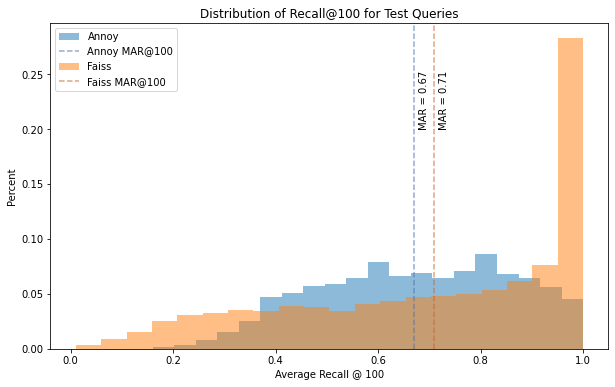

In [153]:
annoy_mean = np.mean(annoy_recall)
annoy_plot_weights = np.ones(len(annoy_recall)) / len(annoy_recall)
faiss_mean = np.mean(faiss_recall)
faiss_plot_weights = np.ones(len(faiss_recall)) / len(faiss_recall)


n1, _, _ = plt.hist(annoy_recall, weights=annoy_plot_weights, bins=20, alpha=0.5, label="Annoy")
plt.axvline(annoy_mean, color="#4c72b0", alpha=0.6, ls="--", label="Annoy MAR@100")

n2, _, _ = plt.hist(faiss_recall, weights=faiss_plot_weights, bins=20, alpha=0.5, label="Faiss")
plt.axvline(faiss_mean, color="#cc642a", alpha=0.6, ls="--", label="Faiss MAR@100")

plot_height = max(np.max(n1), np.max(n2))  # in y-axis units
plt.text(annoy_mean + 0.01, plot_height*0.8, "MAR = {:.2f}".format(annoy_mean), rotation=90, verticalalignment="center")
plt.text(faiss_mean + 0.01, plot_height*0.8, "MAR = {:.2f}".format(faiss_mean), rotation=90, verticalalignment="center")

plt.legend()
plt.title("Distribution of Recall@100 for Test Queries")
plt.xlabel("Average Recall @ 100")
plt.ylabel("Percent")

plt.savefig("output.png")
plt.show()

In [128]:
# stepping through depths
annoy_mar = []
depth = []
k = 300
test_size = glove25_test_np[:100].shape[0]

# can precompute in a batch
_, faiss_estimated = faiss_index.search(glove25_test_np_norm[0:100], k)

annoy_results = np.zeros((test_size, k), dtype=np.float32)
faiss_results = np.zeros((test_size, k), dtype=np.float32)
results_summary = []

# TODO: YOU SHOULD JUST GET TOP 300 at once
for d in tqdm(range(1, k+1)):
  # annoy_recall = []
  # faiss_recall = []
  for i, x in enumerate(glove25_test_np[0:100]):
    annoy_results[i, d-1] = average_recall(
      glove25_test_neighbors[i, :d], # row vector
      annoy_index.get_nns_by_vector(x, n=d), 
      k=d
    )
    faiss_results[i, d-1] = average_recall(
      glove25_test_neighbors[i, :d], # row vector
      faiss_estimated[i, :d],
      k=d
    )
  # summary of each iteration
  results_summary.append({
    "k": d,
    "annoy_mar": np.mean(annoy_results[:,d-1]),
    "faiss_mar": np.mean(faiss_results[:,d-1]),
  })

# gather
results_summary_df = pd.DataFrame.from_records(results_summary)
results_summary_df.info()

100%|██████████| 300/300 [00:59<00:00,  5.06it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   k          300 non-null    int64  
 1   annoy_mar  300 non-null    float32
 2   faiss_mar  300 non-null    float32
dtypes: float32(2), int64(1)
memory usage: 4.8 KB


In [129]:
results_summary_df

,k,annoy_mar,faiss_mar
0,1,0.280000,0.740000
1,2,0.310000,0.745000
2,3,0.366667,0.746667
3,4,0.407500,0.737500
4,5,0.402000,0.744000
...,...,...,...
295,296,0.773378,0.674899
296,297,0.773603,0.674983
297,298,0.773691,0.674832
298,299,0.774013,0.674749


In [130]:
results_summary[:3]

[{'k': 1, 'annoy_mar': 0.28, 'faiss_mar': 0.74},
 {'k': 2, 'annoy_mar': 0.31, 'faiss_mar': 0.745},
 {'k': 3, 'annoy_mar': 0.36666664, 'faiss_mar': 0.7466667}]

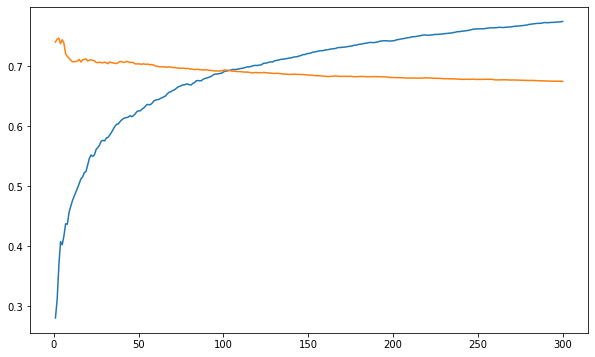

In [131]:
plt.plot(results_summary_df["k"], results_summary_df["annoy_mar"])
plt.plot(results_summary_df["k"], results_summary_df["faiss_mar"])

In [134]:
idx = np.random.choice(glove25_test_np_norm.shape[0], 1)[0]
print(glove25["neighbors"][idx, 0:10])
# print(kd_tree.query(glove25_test_np_norm[idx:idx+1], k=10, return_distance=False)[0])

[ 818827  139910  602482  969152  110152 1181867 1068763 1176247  957190
  847581]
[ 818827  139910  602482  969152  110152 1181867 1068763 1176247  957190
  847581]


In [179]:
idx = np.random.choice(glove25_test_np_norm.shape[0], 1)[0]
print(glove25["neighbors"][idx, 0:10])
print(annoy_index.get_nns_by_vector(glove25_test_np[idx], n=10))

[ 656834  630490  666542  282065  850352 1109499  777257  940789  714248
  693978]
[282065, 850352, 1109499, 719995, 854232, 524252, 246420, 931804, 676274, 486301]


In [175]:
glove25_test_np_norm[idx:idx+1]

array([[-0.19587114,  0.07153555, -0.00206277,  0.04484342, -0.09216353,
        -0.17486468,  0.26796073, -0.15394048, -0.05431128, -0.03687583,
        -0.01021141,  0.37789157,  0.37822068,  0.47693107,  0.00649037,
         0.3479411 ,  0.13291755,  0.01093137,  0.26116428,  0.13078098,
         0.18073682,  0.1423004 ,  0.12842499,  0.05581978, -0.07398205]],
      dtype=float32)

In [43]:
nn[0]

array([      0,  978088,  872508,  343384,  358369, 1092200,  675886,
        379223,  355593,  406832])

In [44]:
glove25["neighbors"][0, 0:10]

array([1086211, 1034304,  377924,   92191,  410858,  970642,  193105,
       1063148,  235005,  914908], dtype=int32)

In [35]:
glove25["neighbors"][0, 0:10]

array([1086211, 1034304,  377924,   92191,  410858,  970642,  193105,
       1063148,  235005,  914908], dtype=int32)